In [1]:
pip install transformers torch sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
pip install --upgrade datasets


In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
from torch.utils.data import Dataset as TorchDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [5]:
df = pd.read_csv("category_wikipedia_articles.csv")
unique_categories = df['Category'].unique()
print("Unique values in the 'category' column:")
print(unique_categories)

Unique values in the 'category' column:
['Mathematics' 'Fields of mathematics' 'Mathematics-related lists'
 'Biology' 'Branches of biology' 'Organisms' 'Biologists'
 'Biology-related lists' 'Geography' 'Geographers'
 'Geography-related lists' 'History' 'History by ethnic group'
 'History by period' 'Fields of history' 'Historiography' 'Science'
 'Branches of science' 'Scientific disciplines' 'Scientists'
 'Science in society']


In [6]:
category_mapping = {
    'Fields of mathematics': 'Mathematics',
    'Mathematics-related lists': 'Mathematics',
    'Branches of biology': 'Biology',
    'Organisms': 'Biology',
    'Biologists': 'Biology',
    'Biology-related lists': 'Biology',
    'Geographers': 'Geography',
    'Geography-related lists': 'Geography',
    'History by ethnic group': 'History',
    'History by period': 'History',
    'Fields of history': 'History',
    'Historiography': 'History',
    'Branches of science': 'Science',
    'Scientific disciplines': 'Science',
    'Scientists': 'Science',
    'Science in society': 'Science'
}
df['Category'] = df['Category'].replace(category_mapping)
print(df['Category'].unique())

['Mathematics' 'Biology' 'Geography' 'History' 'Science']


In [7]:
class CustomDataset(TorchDataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        label = torch.tensor(label, dtype=torch.long)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }

In [8]:
df['Content'] = df['Content'].astype(str).fillna("")
texts = df['Content'].tolist()

label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])


model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)


texts = df['Content'].tolist()
labels = df['Category'].tolist()
max_length = 128


train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)


num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir='./results',
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=10,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

eval_results = trainer.evaluate()
print(eval_results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.591800
20,1.296600
30,1.117000
40,0.904600
50,0.504500
60,0.286400
70,0.225200
80,0.237700
90,0.091700
100,0.118100


{'eval_loss': 0.13386110961437225, 'eval_runtime': 47.773, 'eval_samples_per_second': 2.093, 'eval_steps_per_second': 0.272, 'epoch': 3.0}


Confusion Matrix:
[[14  0  0  0  0]
 [ 0 10  0  0  0]
 [ 1  0 22  0  1]
 [ 0  0  0 28  0]
 [ 1  0  1  0 22]]
Classification Report:
              precision    recall  f1-score   support

     Biology       0.88      1.00      0.93        14
   Geography       1.00      1.00      1.00        10
     History       0.96      0.92      0.94        24
 Mathematics       1.00      1.00      1.00        28
     Science       0.96      0.92      0.94        24

    accuracy                           0.96       100
   macro avg       0.96      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100



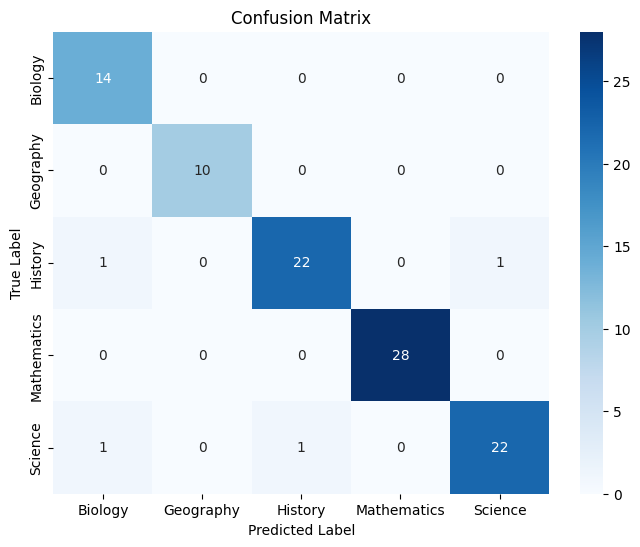

In [9]:
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = np.array(val_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)
class_report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)



plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
